# Open Street Map

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import geopandas as gpd
from shapely import wkt, geometry
import fiona
from osgeo import gdal_array
from osgeo import gdal, osr, ogr
from osgeo import ogr, osr
import pyproj
import math
warnings.filterwarnings('ignore')
print("NumPy version: %s"%np.__version__)
print("Pandas version: %s"%pd.__version__)
print("GeoPandas version: %s"%gpd.__version__)
print("GDAL version: %s"%gdal.__version__)

NumPy version: 1.23.1
Pandas version: 1.4.3
GeoPandas version: 0.11.1
GDAL version: 3.5.1


## OSM data
We select the data about buildings using the [overpass-turbo](https://overpass-turbo.eu/) web service. The area is Novate Milanese. The query to select the data is

```
/*
This has been generated by the overpass-turbo wizard.
The original search was:
“roof:shape=*”
*/
[out:json][timeout:100];
// gather results
(
  // query part for: “"roof:shape"=*”
  way["roof:shape"](45.51482779887124,9.093246459960938,45.55168379775144,9.183025360107422);
);
// print results
out body;
>;
```


In [2]:
osm_path = 'data/vector/OSM/osm_overpass_novate_milanese.geojson'

In [3]:
osm_data = gpd.read_file(osm_path)
osm_data['roof:shape'].shape

(1080,)

In [4]:
osm_data.head(2)

id           @id addr:city addr:country addr:housenumber  \
0  way/25310685  way/25310685      None         None             None   
1  way/25310687  way/25310687      None         None             None   

  addr:postcode addr:street amenity bicycle_parking brand  ...  shop source  \
0          None        None    None            None  None  ...  None   None   
1          None        None    None            None  None  ...  None   None   

  sport start_date tourism vaccination website wheelchair wikidata  \
0  None       None    None        None    None       None     None   
1  None       None    None        None    None       None     None   

                                            geometry  
0  POLYGON ((9.12268 45.51878, 9.12267 45.51864, ...  
1  POLYGON ((9.12285 45.51971, 9.12291 45.51971, ...  

[2 rows x 70 columns]

In [5]:
osm_data.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [6]:
novate_buildings = osm_data[:][['id', 'roof:shape', 'geometry']]
novate_buildings.head(2)

id roof:shape                                           geometry
0  way/25310685     hipped  POLYGON ((9.12268 45.51878, 9.12267 45.51864, ...
1  way/25310687     hipped  POLYGON ((9.12285 45.51971, 9.12291 45.51971, ...

In [7]:
import folium
m = folium.Map(location=[45.5323, 9.1366], zoom_start=14, tiles='cartodbpositron')
folium.GeoJson(novate_buildings).add_to(m)
folium.GeoJson(novate_buildings, style_function=lambda x: {'fillColor': 'green'}).add_to(m)
folium.LatLngPopup().add_to(m)
m

In [8]:
novate_epsg_32633_gdf = novate_buildings.copy()

In [9]:
novate_epsg_32633_gdf.to_crs(epsg=32633, inplace=True)

In [10]:
novate_epsg_32633_gdf.crs

<Derived Projected CRS: EPSG:32633>
Name: WGS 84 / UTM zone 33N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 12°E and 18°E, northern hemisphere between equator and 84°N, onshore and offshore. Austria. Bosnia and Herzegovina. Cameroon. Central African Republic. Chad. Congo. Croatia. Czechia. Democratic Republic of the Congo (Zaire). Gabon. Germany. Hungary. Italy. Libya. Malta. Niger. Nigeria. Norway. Poland. San Marino. Slovakia. Slovenia. Svalbard. Sweden. Vatican City State.
- bounds: (12.0, 0.0, 18.0, 84.0)
Coordinate Operation:
- name: UTM zone 33N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [11]:
path = 'data/raster/Pleiades/'
patch_fn = os.path.join(path, 'pan_patch.tif')

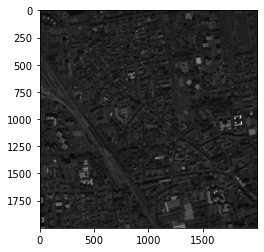

In [12]:
from PIL import Image, ImageDraw
im_patch = Image.open(patch_fn)
#print('Image format: {}\nShape (rows, cols): {}\nMode: {}'.format(im_band2.format, im_band2.size, im_band2.mode))
plt.imshow(im_patch, cmap='gray')

In [13]:
def get_raster_bbox(fn):
    '''
    Returns the coordinates of the upper left (north west) and
    lower right (south east) pixels of the raster file.
    '''
    ds = gdal.Open(fn)
    gt = ds.GetGeoTransform()
    north_west_x = gt[0]  # min long
    north_west_y = gt[3]  # max lat
    x_pixel_resolution = gt[1]
    y_pixel_resolution = gt[5]
    south_east_x = north_west_x + x_pixel_resolution * ds.RasterXSize # max long
    south_east_y = north_west_y + y_pixel_resolution * ds.RasterYSize # min lat
    return [[north_west_x, north_west_y], [south_east_x, south_east_y]]

In [14]:
#from skimage import io
path_target = 'data/raster/Landsat/Italy/LC09_L1TP_190031_RGB_subset.tif'
get_raster_bbox(path_target)

[[369885.0, 4577715.0], [389895.0, 4557705.0]]

In [15]:
source_ds = gdal.Open(path_target)
source_ds.GetProjection()

'PROJCS["WGS 84 / UTM zone 33N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",15],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32633"]]'

In [16]:
data = source_ds.ReadAsArray()
data.shape

(3, 667, 667)

In [17]:
data_t = np.transpose(data, (1, 2, 0))
data_t.shape

(667, 667, 3)

In [29]:
import rasterio as rio
#import folium
from pyproj import Transformer 

## RGB Image
#in_path = 'data/raster/Landsat/Italy/LC09_L1TP_190031_RGB_subset.tif'
in_path = patch_fn
dst_crs = 'EPSG:4326'


with rio.open(in_path) as src:
    img = src.read()
    src_crs = src.crs['init'].upper()
    min_lon, min_lat, max_lon, max_lat = src.bounds
    
src_crs, min_lon, min_lat, max_lon, max_lat

('EPSG:3035', 4252896.75, 2491172.2499999995, 4253896.75, 2492172.2499999995)

In [30]:
## Conversion from UTM to WGS84 CRS
bounds_orig = [[min_lat, min_lon], [max_lat, max_lon]] # 
bounds_orig

[[2491172.2499999995, 4252896.75], [2492172.2499999995, 4253896.75]]

In [31]:
bounds_fin = []
for item in bounds_orig:   
    #converting to lat/lon
    lat = item[0]
    lon = item[1]
    
    proj = Transformer.from_crs(int(src_crs.split(":")[1]), int(dst_crs.split(":")[1]), always_xy=True)
    lon_n, lat_n = proj.transform(lon, lat)
    bounds_fin.append([lat_n, lon_n])

bounds_fin

[[45.52939868138317, 9.129453043159215],
 [45.53851316375679, 9.142094158916143]]

In [32]:
# Finding the centre latitude & longitude    
centre_lon = bounds_fin[0][1] + (bounds_fin[1][1] - bounds_fin[0][1])/2
centre_lat = bounds_fin[0][0] + (bounds_fin[1][0] - bounds_fin[0][0])/2
centre_lon, centre_lat 

(9.135773601037679, 45.53395592256998)


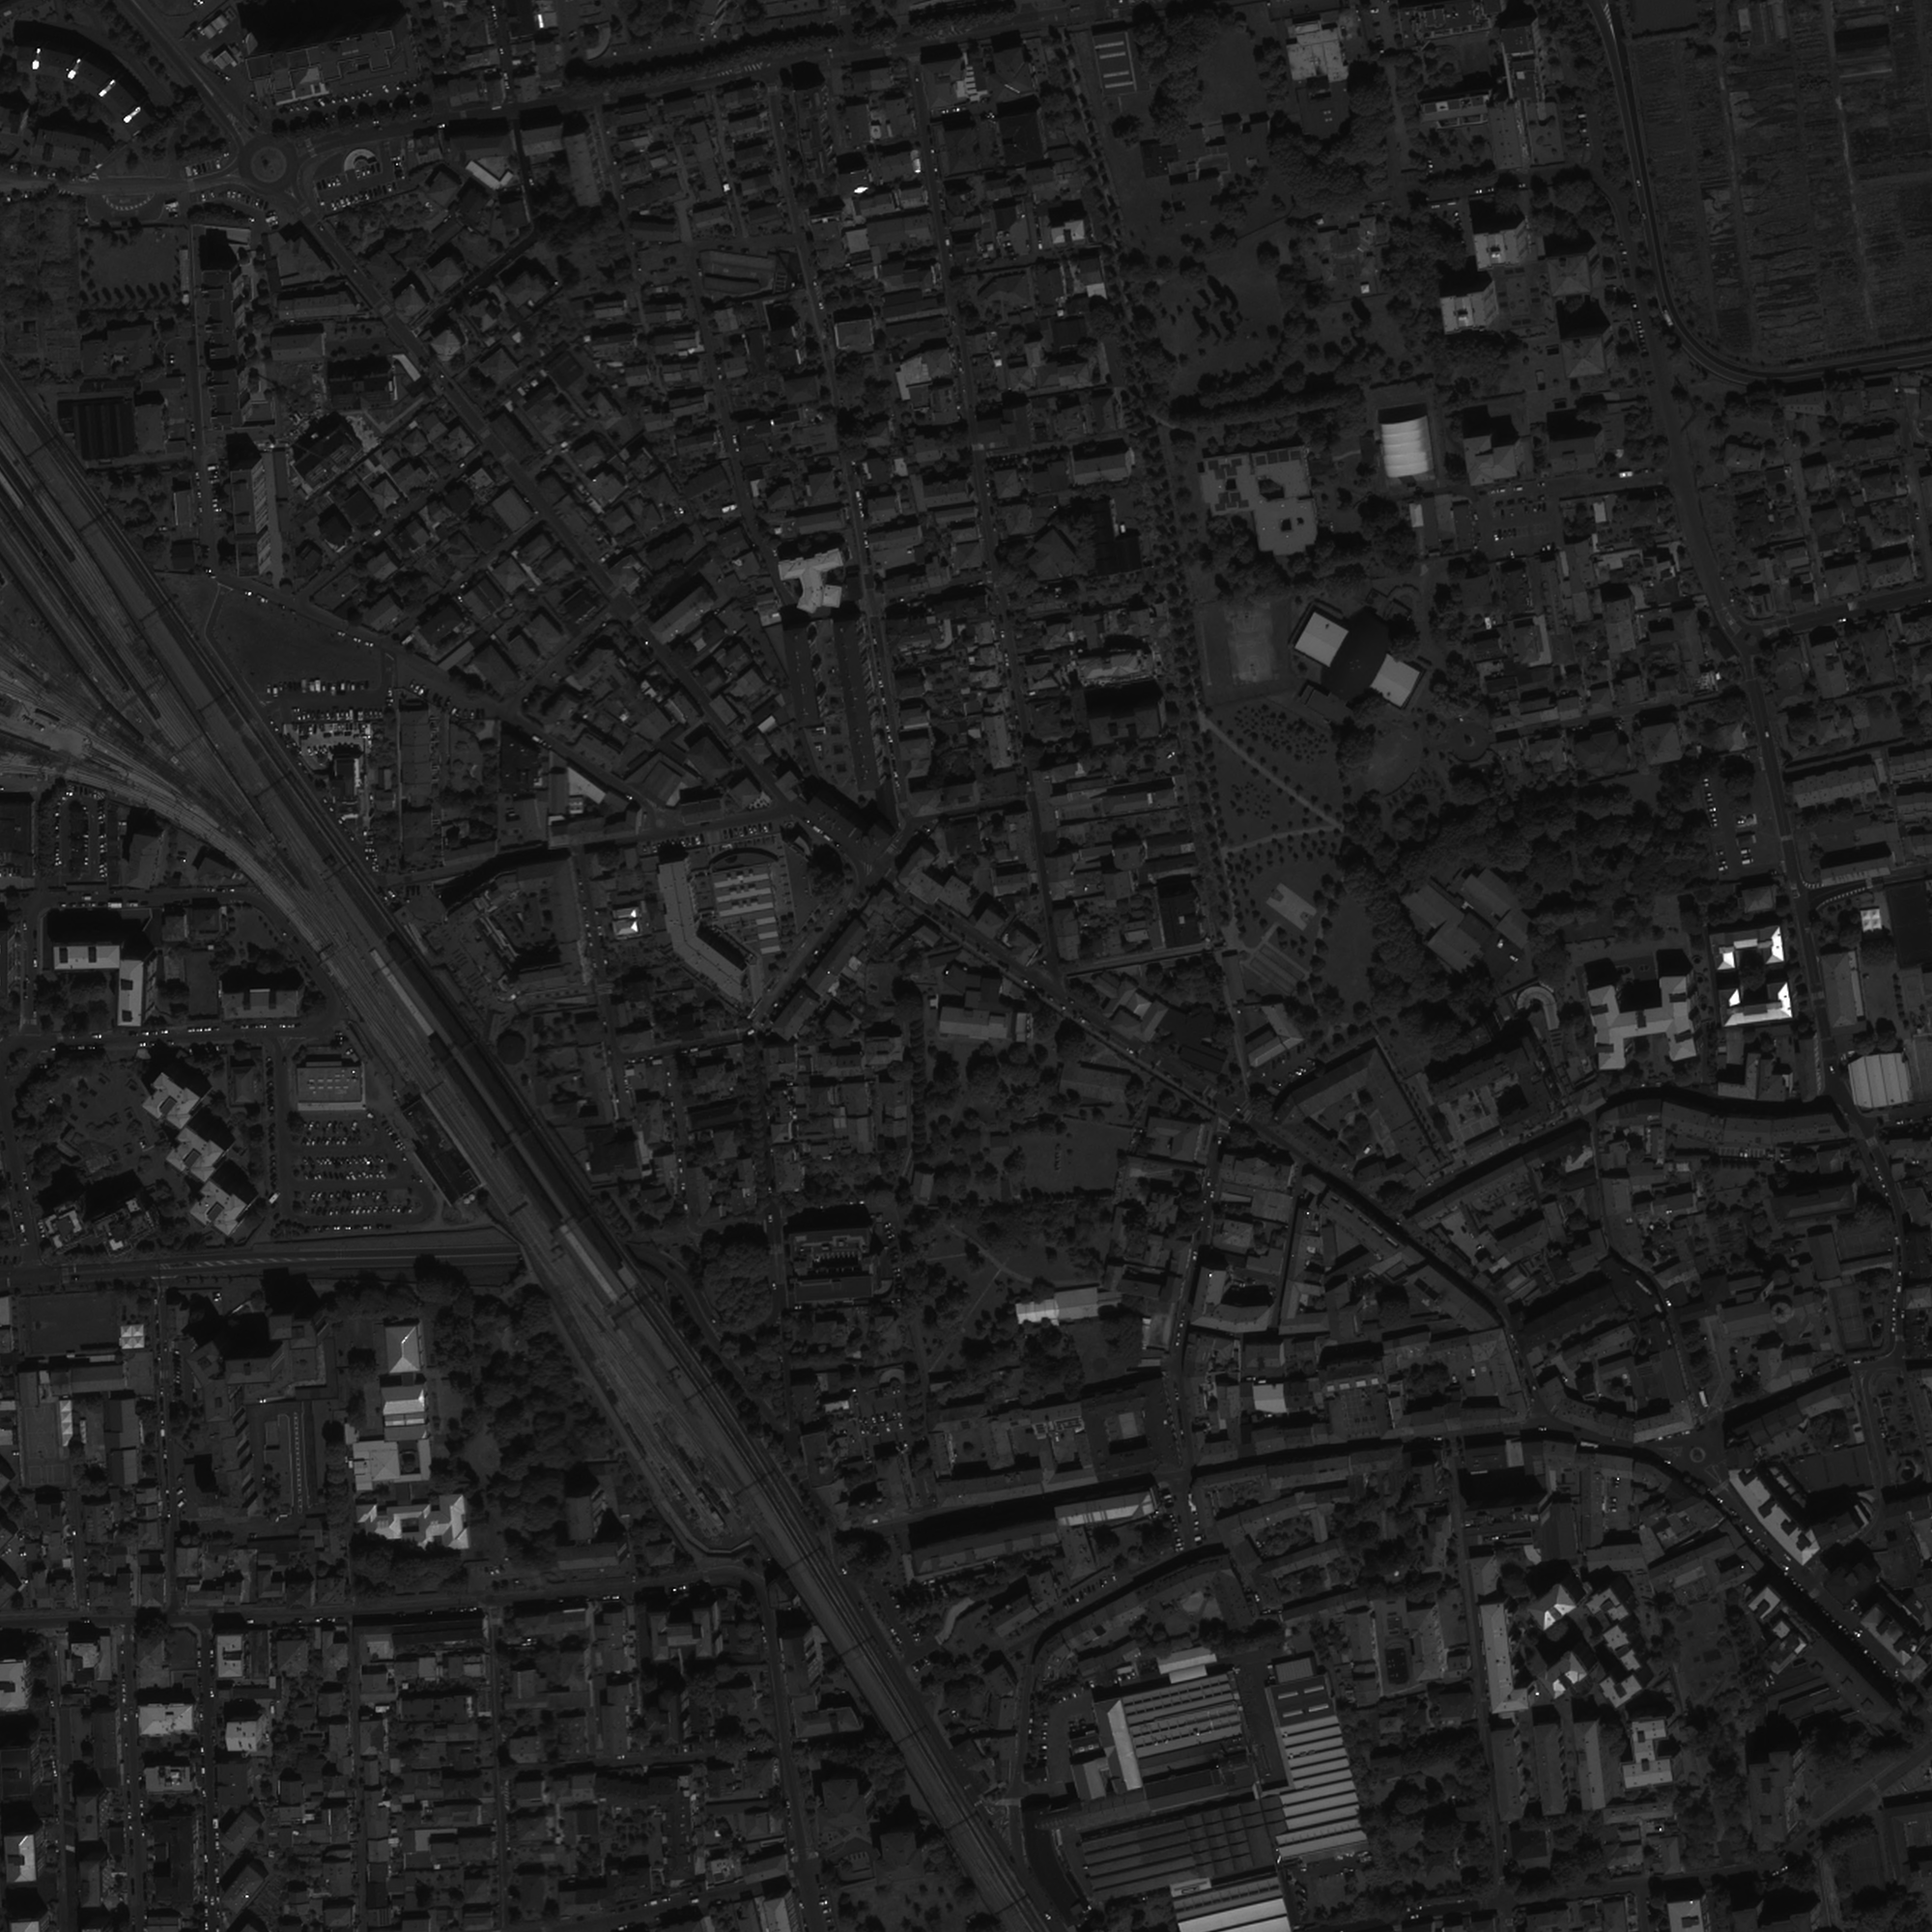

In [38]:
map = folium.Map(location=[centre_lat, centre_lon], tiles='Stamen Terrain', zoom_start = 15)

# Overlay raster (RGB) called img using add_child() function (opacity and bounding box set)
map.add_child(folium.raster_layers.ImageOverlay(img.transpose(1, 2, 0), 
                                                opacity=.9, 
                                                bounds = bounds_fin, 
                                                name='panchromatic'))

folium.GeoJson(novate_buildings, name='OSM').add_to(map)
# Display map 
map.add_child(folium.LayerControl())

map